In [1]:
clean_up=True # removes gams-related files in work-folder if true
%run StdPackages.ipynb
os.chdir(directory['py'])
import techdata_to_tree, sys, ShockFunction
import abatement_ID_calib as abatement
os.chdir(directory['curr'])

The file_gams_py_gdb1.gdx is still active and was not deleted.
The file_gams_py_gdb2.gdx is still active and was not deleted.
The file_gams_py_gdb4.gdx is still active and was not deleted.
The file_gams_py_gdb5.gdx is still active and was not deleted.


*Specify settings:*

In [2]:
name = 'A1_calib_test'
f = {'tech': directory['data']+"/techdata_dors_2.xlsx",
     'other': directory['data']+"/Othdata_dors_2.xlsx",
     'IO':directory['data'] + "/IOdata_dors_2.xlsx"}
s = ['inputdisp','endofpipe','inputprices']
m = ['ID','EOP'] 
e = {'M': 'vars','M_sets': 'sets'} # dictionary used to load emissions data
other_trees = {'ID_Y': {'s': 'Y', 'read_data': {'Y': 'vars'}, 'Q2P': 'Q2P'}} # the key = tree name, s = sheet that specifies tree structure, read_data (if not None) specifies how to load data.

In [3]:
type_f = {'ID_EC': 'CES_norm',
          'ID_CU': 'MNL',
          'ID_TU': 'CET_norm',
          'ID_TX': 'CES',
          'ID_BU': 'linear_out',
          'ID_BX': 'CES',
          'EOP_CU': 'MNL',
          'EOP_TU': 'CET_norm',
          'EOP_TX': 'CES'}

*Set up nesting tree:*

In [4]:
%run ATree.ipynb

## 1: Initialize model

*Set up gams model from tree:*

In [5]:
gm = abatement.abate(nt=nts['ID'],tech=tech,work_folder=directory['work'],**{'data_folder':directory['gams'],'name': name})

*Add a couple of extra aliases, and update sets with elements:*

In [6]:
gm.add_aliases([('n','nnnn'),('n','nnnnn')])
gm.model.database.update_all_sets(clean_up=False)

*Initialise variables at leontief levels, and fill out with simple standard values in potentially missing domains:*

In [7]:
gm.initialize_variables_leontief()
gm.initialize_variables(**{'check_variables': True})

## 2: Solve model

*Set up baseline model and solve:*

In [8]:
gm.write_and_run(name='baseline')
db0 = gm.model_instances['baseline'].out_db

*Read back solution to main db:*

In [9]:
gm.model.database.merge_dbs(gm.model.database,db0,'second')

*Turn exogenous parameters into place*

In [10]:
db_star = DataBase.GPM_database(**{'name': 'db_star'})
sigma_star = gm.get("sigma").copy()
eta_star = gm.get("eta").copy()
mu_star = gm.get("mu").copy()

eta_star[:] = -3
sigma_star[gm.get("kno_ID_CU")] = 0.4
sigma_star[gm.get("kno_no_ID_BX")] = 0.7
sigma_star["Y"] = 0.5

mu_star[gm.get("map_ID_CU")] = 1.0

db_star["sigma"] = sigma_star
db_star["eta"] = eta_star
db_star["mu"] = mu_star

In [11]:
name='v0'
gm.write_and_run(name=name, add_checkpoint=name)
gm.checkpoints['v1'] = gm.model_instances[name].ws.add_checkpoint()
gm.model_instances[name].solve_sneakily(db_star=db_star,from_cp = True, cp_init = gm.checkpoints[name], options_run={'checkpoint': gm.checkpoints['v1']})
gm.model.database.merge_dbs(gm.model.database,gm.model_instances[name].out_db,'second')

In [12]:
db_star = DataBase.GPM_database(**{'name': 'db_star'})
sigma_star = gm.get("sigma").copy()
sigma_star[gm.get("kno_ID_CU")] = 5
db_star["sigma"] = sigma_star

In [13]:
(shock_db, shock_kwargs) = ShockFunction.sneaky_db(gm.model.database, db_star, n_steps = 200, loop_name = 'sigma_loop')
store_sol = {"PwThat":{'domains': shock_kwargs['loop_name']}, "qD":{'domains': shock_kwargs['loop_name']}, "sigma":{'domains': shock_kwargs['loop_name']}}
mi = gm.model_instances[name]
shock = mi.std_UEVAS_from_db(shock_db, loop_name=shock_kwargs['loop_name'], shock_name=shock_kwargs['shock_name'], store_sol=store_sol)
mi.execute_shock_from_cp(shock=shock, cp=gm.checkpoints['v1'])
gm.model.database.merge_dbs(gm.model.database,mi.out_db,'second')

*Change to calibration state and resolve:*

In [14]:
gm.reset_settings()
gm.setstate('ID_calibrate',init=False)
gm.write_and_run(name='ID_calibrate',kwargs_init={'check_variables':True},overwrite=True)
db = gm.model_instances['ID_calibrate'].out_db

Load in IO data

In [16]:
gm.add_calib_data(f["IO"])

In [29]:
# db = DataBase.GPM_database()
# qD = gm.get("qD").copy()

# qD[gm.get("bra_ID_BX")] = qD[gm.get("bra_ID_BX")] + 0.25
# qD["Y_oil"] = qD["Y_oil"] - 1
# db["qD"] = qD

# DataBase.GPM_database.merge_dbs(gm.model.database, db, "second")

In [18]:
gm.write_and_run(name='ID_calibrate',kwargs_init={'check_variables':True},overwrite=True)
db = gm.model_instances['ID_calibrate'].out_db

*Print some... Note that if the ID technologies do not have any overlap with other technologies, the calibration procedure only has one possible solution; i.e. there are not any room for really minimizing the minobj.*

In [19]:
def compare_plots(db0,db,var):
    return pd.concat([db0.get(var).rename(f"{var}, B"),db.get(var).rename(f"{var}, C")],axis=1).plot.bar();

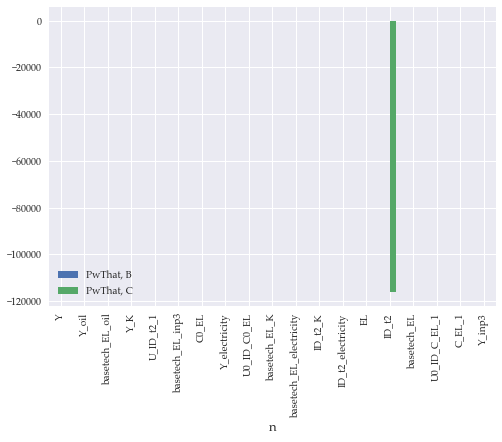

In [21]:
var = 'PwThat'
compare_plots(db0,db,var)

<AxesSubplot:xlabel='n'>

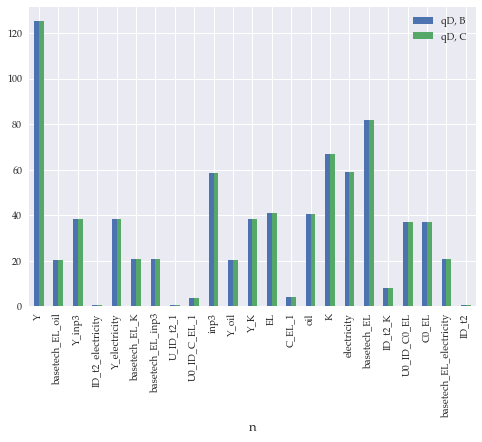

In [13]:
var = 'qD'
compare_plots(db0,db,var)

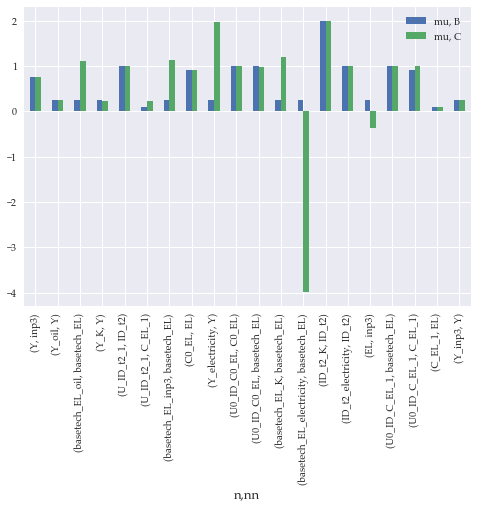

In [22]:
var="mu"
compare_plots(db0,db,var)

## 3: Test that the baseline model is also solved with the new calibrated values:

## A: Additional equations

### Current application

* Define currapp[n,nn] as the share of energy-services covered by technology goods produced by technology $nn$ to satisfy the energy-service need $n$. In other words:

$$\begin{align}
    \text{currapp[n,nn]} =\text{sum(nnn\$(e2u[n,nnn]), qD[nnn])} / qD[n].
\end{align}$$

* Define the technology shares $U/C$ as $s\_uc[u,c]$ as the shares under the counterfactual scenario outlined in the article. Specifically:

$$\begin{align}
    \text{s_uc[n,nn]} &= \dfrac{exp\left(\sigma[nn]\left(PwThat[nn]-PwThat[n]\right)\right)\mu[n,nn]}{sum\left[nnn\$(\text{non-baseline}[nnn]), share[nnn]\right]+sum\left[nnn\$(\text{baseline}[nnn]) shareB[nnn]\right]} \\ 
    \sum share[nnn] &= sum\left[nnn\$\left(u2c[nnn,nn]\text{ and }bra\_ID\_TU[nnn]\right), \mu[nnn,nn] exp\left(\sigma[nn]\left(PwThat[nn]-PwThat[nnn]\right)\right)\right] \\ 
    \sum shareB[nnn]&= sum\left[nnn\$\left(u2c[nnn,nn]\text{ and }bra\_ID\_BU[nnn]\right), \mu[nnn,nn] exp\left(\sigma[nn]\left(PwThat[nn]-PwThatX[nnn]\right)\right)\right]
\end{align}$$
where the $share[nnn]$ is the MNL-like contribution from non-baseline goods in the relevant nest, and $shareB[nnn]$ is the MNL-like contribution from baseline goods. This price is adjusted here, to reflect a technology level ($\tau$ instead of $U$) price:

$$\begin{align}
    PwThatX[nnn] = sum\left[nnnn\$\left(e2u[nnnn,n]\right), sum(nnnnn\$(u2t[n,nnnnn]), gamma\_tau[nnnn,nnnnn]) * sum(nnnnn\$\left(u2t[nnn,nnnnn]\right), PwThat[nnnnn])\right]
\end{align}$$

Here we have: $n$ = technology good, $nn$ = relevant component, $nnn$ = baseline good $U$ in the same nest as good $n$, $nnnn$ = relevant energy-service nest, and $nnnnn$ first identifies the relevant technology $(\tau)$ to good $n$, and afterwards the relevant technology $(\tau)$ to good $nnn$.

Here, the first part identifies the relevant energy-service that good $U$ contributes to. The second part then first identifies the technology-specific component and picks out the $(e,\tau)$ parameter in gamma\_tau. This is multiplied by the baseline technology price. 

* Define the modified current application $currapp\_mod[n,nn]$ level with $n$ = energy-service and $nn$=technology:

$$\begin{align}
    \text{currapp_mod[n,nn]} = \text{sum([nnn,nnnn]\$(u2t[nnn,nn] and c2e[nnnn,n]), s_uc[nnn,nnnn]*qD[nnnn]/qD[n])}
\end{align}$$

This takes the hypothetical share $U/C$ and multiplies by the actual share $C/E$. 